<a href="https://colab.research.google.com/github/Blaizzy/Cancer_classifier/blob/Blaizzy-beta/Inception_v3_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InceptionV3 fine tune
      -Pre-trained Model Approach

              1.  Select Source Model. A pre-trained source model is chosen from available models. Many research institutions release models on large and challenging datasets that may be included in the pool of candidate models from which to choose from.
              2.  Reuse Model. The model pre-trained model can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modeling technique used.
              3. Tune Model. Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.
This second type of transfer learning is common in the field of deep learning.

In [0]:
from google.colab import files 
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Importing Kaggle.json**

In [0]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blaizzy","key":"1a94cbea93dd6fb8d2b83e57ab97c880"}'}

Set-up

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


** Verify Json**

In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 Mar  2 10:15 kaggle.json
{"username":"blaizzy","key":"1a94cbea93dd6fb8d2b83e57ab97c880"}

**Install Kaggle packages**

In [0]:
!pip install -q kaggle 
!pip install -q kaggle-cli

    100% |████████████████████████████████| 81kB 5.1MB/s 
    100% |████████████████████████████████| 5.3MB 5.1MB/s 
    100% |████████████████████████████████| 92kB 26.3MB/s 
    100% |████████████████████████████████| 51kB 20.6MB/s 


**Kaggle datasets**

In [0]:
import os 

os.chdir('/content/drive/My Drive/')
# !mkdir nih-chest-xrays

In [0]:
!kaggle datasets download "nih-chest-xrays/sample"

100% 2.09G/2.10G [00:35<00:00, 56.2MB/s]
100% 2.10G/2.10G [00:35<00:00, 63.7MB/s]


In [0]:
!unzip sample.zip

Archive:  sample.zip
  inflating: images/00000013_005.png  
  inflating: images/00000013_026.png  
  inflating: images/00000017_001.png  
  inflating: images/00000030_001.png  
  inflating: images/00000032_001.png  
  inflating: images/00000040_003.png  
  inflating: images/00000042_002.png  
  inflating: images/00000057_001.png  
  inflating: images/00000061_002.png  
  inflating: images/00000061_019.png  
  inflating: images/00000061_025.png  
  inflating: images/00000079_000.png  
  inflating: images/00000080_005.png  
  inflating: images/00000083_000.png  
  inflating: images/00000084_000.png  
  inflating: images/00000096_006.png  
  inflating: images/00000099_003.png  
  inflating: images/00000099_006.png  
  inflating: images/00000103_001.png  
  inflating: images/00000116_013.png  
  inflating: images/00000116_019.png  
  inflating: images/00000116_032.png  
  inflating: images/00000116_040.png  
  inflating: images/00000118_011.png  
  inflating: images/00000121_004.png  
  in

# Import

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras import backend as K
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from glob import glob
import numpy as np

# EDA - Exploratory Data Analysis


In [0]:
os.chdir('/content/drive/My Drive/nih-chest-xrays')
df = pd.read_csv("sample_labels.csv")


In [0]:
# Get Image paths to append to our csv
image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/content/drive/My Drive/nih-chest-xrays/images/', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', df.shape[0])

Scans found: 5606 , Total Headers 5606


In [0]:
df['paths'] = df['Image Index'].map(image_paths.get)

In [0]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,paths
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/content/drive/My Drive/nih-chest-xrays/images...
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/content/drive/My Drive/nih-chest-xrays/images...
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/content/drive/My Drive/nih-chest-xrays/images...
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/content/drive/My Drive/nih-chest-xrays/images...
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/content/drive/My Drive/nih-chest-xrays/images...


In [0]:
des_df = df.describe()
des_df.T

,count,mean,std,min,25%,50%,75%,max
Follow-up #,5606.0,8.616661,15.565815,0.000,0.000,3.000,10.000,177.0000
Patient ID,5606.0,14330.617017,8411.477789,13.000,7289.000,13993.000,20655.500,30797.0000
OriginalImageWidth,5606.0,2644.795755,347.188754,1362.000,2500.000,2542.000,2992.000,3266.0000
OriginalImageHeight,5606.0,2491.087406,399.119063,966.000,2048.000,2544.000,2991.000,3056.0000
OriginalImagePixelSpacing_x,5606.0,0.155467,0.016201,0.115,0.143,0.143,0.168,0.1988
OriginalImagePixelSpacing_y,5606.0,0.155467,0.016201,0.115,0.143,0.143,0.168,0.1988


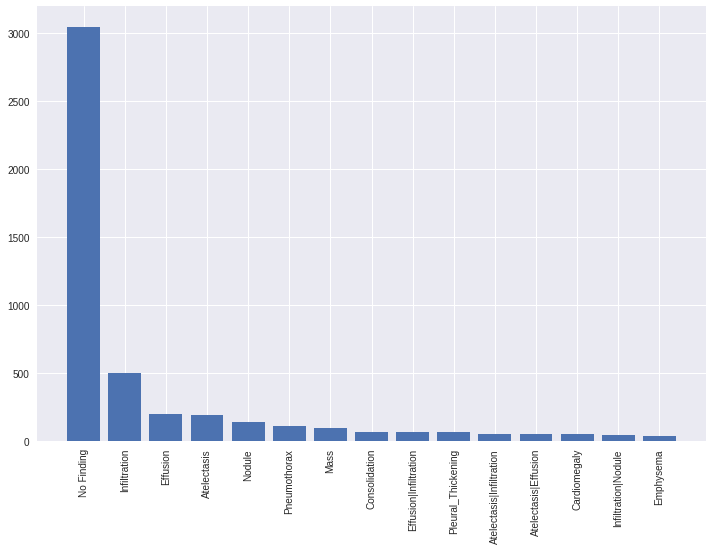

In [0]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [0]:
# df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding',''))
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
# print('All Labels ({}): {}'.format(len(all_labels), all_labels))
# for c_label in all_labels:
#     if len(c_label)>1: # leave out empty labels
#        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
# df.sample(3)

In [0]:
# keep at least 1000 cases
MIN_CASES = 100
all_labels = [i for i in all_labels if df[i].sum()>MIN_CASES]

print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(df[c_label].sum())) for c_label in all_labels])

In [0]:
#eliminating null values
df = df[~df['Finding Labels'].str.contains('No Finding')]

In [0]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,paths
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,/content/drive/My Drive/nih-chest-xrays/images...
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,/content/drive/My Drive/nih-chest-xrays/images...
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,/content/drive/My Drive/nih-chest-xrays/images...
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,/content/drive/My Drive/nih-chest-xrays/images...
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168000,0.168000,/content/drive/My Drive/nih-chest-xrays/images...
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143000,0.143000,/content/drive/My Drive/nih-chest-xrays/images...
10,00000061_025.png,Consolidation|Effusion|Infiltration|Nodule,25,61,077Y,M,AP,3056,2544,0.139000,0.139000,/content/drive/My Drive/nih-chest-xrays/images...
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168000,0.168000,/content/drive/My Drive/nih-chest-xrays/images...
14,00000084_000.png,Effusion,0,84,057Y,F,PA,2048,2500,0.171000,0.171000,/content/drive/My Drive/nih-chest-xrays/images...
15,00000096_006.png,Effusion,6,96,067Y,F,PA,2242,2546,0.143000,0.143000,/content/drive/My Drive/nih-chest-xrays/images...


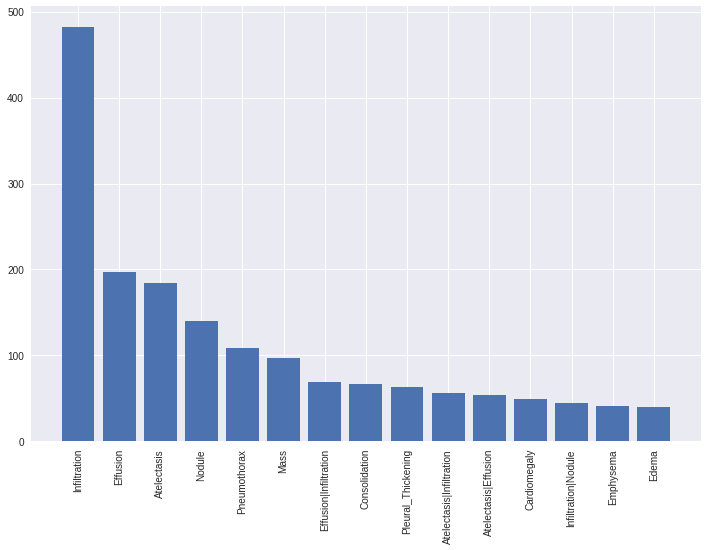

In [0]:

# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>100 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
df =df.sample(2500, weights=sample_weights)

label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Part II


1.   Gain more insights 



In [0]:
labels = pd.read_csv('sample_labels.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


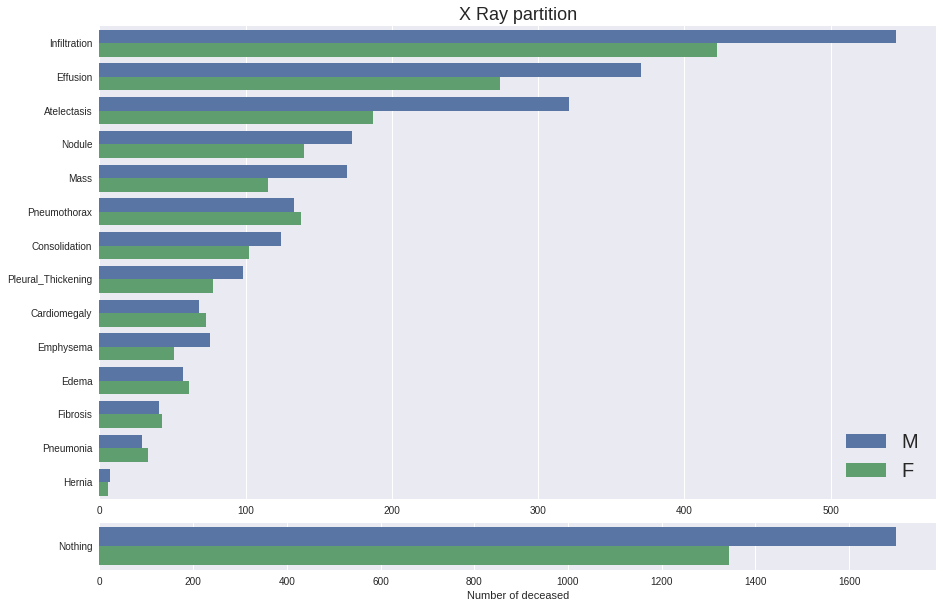

In [0]:
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of infected patient")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

In [0]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,paths
4113,00020259_000.png,"[Atelectasis, Fibrosis]",0,20259,052Y,F,PA,2516,2608,0.139,0.139,./images/00020259_000.png
3116,00015375_004.png,[Pleural_Thickening],4,15375,075Y,M,AP,2500,2048,0.168,0.168,./images/00015375_004.png
486,00002533_003.png,[Edema],3,2533,021Y,M,AP,3056,2544,0.139,0.139,./images/00002533_003.png
4149,00020405_003.png,[Infiltration],3,20405,048Y,M,PA,2698,2991,0.143,0.143,./images/00020405_003.png
4354,00021495_005.png,"[Atelectasis, Consolidation, Effusion, Emphyse...",5,21495,022Y,M,AP,3056,2544,0.139,0.139,./images/00021495_005.png


**Drop useless collumns**

In [0]:
df.drop(['Follow-up #','Patient ID','Patient Age','Patient Gender','View Position','OriginalImageWidth','OriginalImageHeight'
         ,'OriginalImagePixelSpacing_x','OriginalImagePixelSpacing_y'], axis = 1)

,Image Index,Finding Labels,paths
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,/content/drive/My Drive/nih-chest-xrays/images...
1,00000013_026.png,Cardiomegaly|Emphysema,/content/drive/My Drive/nih-chest-xrays/images...
3,00000030_001.png,Atelectasis,/content/drive/My Drive/nih-chest-xrays/images...
4,00000032_001.png,Cardiomegaly|Edema|Effusion,/content/drive/My Drive/nih-chest-xrays/images...
5,00000040_003.png,Consolidation|Mass,/content/drive/My Drive/nih-chest-xrays/images...
8,00000061_002.png,Effusion,/content/drive/My Drive/nih-chest-xrays/images...
10,00000061_025.png,Consolidation|Effusion|Infiltration|Nodule,/content/drive/My Drive/nih-chest-xrays/images...
11,00000079_000.png,Mass,/content/drive/My Drive/nih-chest-xrays/images...
14,00000084_000.png,Effusion,/content/drive/My Drive/nih-chest-xrays/images...
15,00000096_006.png,Effusion,/content/drive/My Drive/nih-chest-xrays/images...


In [0]:
# Saving cleaned csv
df.to_csv('/content/drive/My Drive/nih-chest-xrays/cleaned_sample.csv', index = False)

# Prepare data

In [0]:
# Creating a list of All labels
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

In [0]:
df = pd.read_csv('/content/drive/My Drive/nih-chest-xrays/cleaned_sample.csv')


In [0]:
os.chdir('/content/drive/My Drive/nih-chest-xrays/')

In [0]:
# Creating Image generators that will Augment my dataset 
datagen = ImageDataGenerator(rescale = 1./255., samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

train_gen = datagen.flow_from_dataframe(
dataframe = df[:1900],
directory = '/content/drive/My Drive/nih-chest-xrays/',
x_col ='paths',
y_col ='Finding Labels',
batch_size = 64,
seed = 42,
shuffle = True,
class_mode = 'categorical',
classes = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
           'Emphysema', 'Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening',
           'Pneumonia','Pneumothorax'],
target_size = (299,299))


valid_gen = datagen.flow_from_dataframe(
dataframe = df[1900:2000],
directory = '/content/drive/My Drive/nih-chest-xrays/',
x_col ='paths',
y_col ='Finding Labels',
batch_size = 64,
seed = 42,
shuffle = True,
class_mode = 'categorical',
classes = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
           'Emphysema', 'Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening',
           'Pneumonia','Pneumothorax'],
target_size = (299,299))

test_gen = datagen.flow_from_dataframe(
dataframe = df[2000:],
directory = '/content/drive/My Drive/nih-chest-xrays/',
x_col ='paths',
y_col ='Finding Labels',
batch_size = 64,
seed = 42,
shuffle = True,
class_mode = 'categorical',
classes = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Effusion',
           'Emphysema', 'Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening',
           'Pneumonia','Pneumothorax'],
target_size = (299,299))




Found 1177 images belonging to 13 classes.
Found 66 images belonging to 13 classes.
Found 334 images belonging to 13 classes.


# Build Model

In [0]:
# Model
input_tensor = Input(shape=(299, 299, 3))  
base_model = InceptionV3(input_tensor = input_tensor,weights = 'imagenet', include_top= False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation = 'relu')(x)
drop = Dropout(0.5)(x)
cl = Dense(13, activation = 'sigmoid')(drop)
model = Model(inputs=input_tensor, outputs = cl )
  
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer = 'rmsprop', loss ='binary_crossentropy', metrics= ['accuracy'])

# step_size
STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n//test_gen.batch_size
  

# Training 
history = model.fit_generator(generator = train_gen, steps_per_epoch = train_step,
                   validation_data = valid_gen,
                   validation_steps = valid_step,
                   epochs = 3)

Epoch 1/3
18/18 [==============================] - 75s 4s/step - loss: 0.8139 - acc: 0.8770 - val_loss: 0.8784 - val_acc: 0.9231
Epoch 2/3
18/18 [==============================] - 42s 2s/step - loss: 0.4275 - acc: 0.9055 - val_loss: 0.5608 - val_acc: 0.8462
Epoch 3/3
18/18 [==============================] - 47s 3s/step - loss: 0.2934 - acc: 0.9113 - val_loss: 0.2542 - val_acc: 0.9195


In [0]:
# saving model
model.save_weights('model.h5')

In [0]:

# Training 
history = model.fit_generator(generator = train_gen, steps_per_epoch = train_step,
                   validation_data = valid_gen,
                   validation_steps = valid_step,
                   epochs = 5)

Epoch 1/5
18/18 [==============================] - 54s 3s/step - loss: 0.2702 - acc: 0.9134 - val_loss: 0.2848 - val_acc: 0.9231
Epoch 2/5
18/18 [==============================] - 45s 3s/step - loss: 0.2623 - acc: 0.9180 - val_loss: 0.2798 - val_acc: 0.9231
Epoch 3/5
18/18 [==============================] - 47s 3s/step - loss: 0.2568 - acc: 0.9204 - val_loss: 0.2308 - val_acc: 0.9219
Epoch 4/5
18/18 [==============================] - 45s 2s/step - loss: 0.2537 - acc: 0.9212 - val_loss: 0.2786 - val_acc: 0.9231
Epoch 5/5
18/18 [==============================] - 47s 3s/step - loss: 0.2480 - acc: 0.9218 - val_loss: 0.2447 - val_acc: 0.9231


In [0]:
# saving model
model.save_weights('model.h5')

In [0]:
# Training 
history = model.fit_generator(generator = train_gen, steps_per_epoch = train_step,
                   validation_data = valid_gen,
                   validation_steps = valid_step,
                   epochs = 3)

Epoch 1/3
18/18 [==============================] - 53s 3s/step - loss: 0.2461 - acc: 0.9215 - val_loss: 0.2245 - val_acc: 0.9219
Epoch 2/3
18/18 [==============================] - 45s 2s/step - loss: 0.2499 - acc: 0.9201 - val_loss: 0.2611 - val_acc: 0.9231
Epoch 3/3
18/18 [==============================] - 47s 3s/step - loss: 0.2473 - acc: 0.9231 - val_loss: 0.2307 - val_acc: 0.9231


In [0]:
model.save_weights('model.h5')

In [0]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [0]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss ='binary_crossentropy', metrics= ['accuracy'])

In [0]:
history = model.fit_generator(generator = train_gen, steps_per_epoch = train_step,
                   validation_data = valid_gen,
                   validation_steps = valid_step,
                   epochs = 3)

Epoch 1/3
18/18 [==============================] - 81s 4s/step - loss: 0.2393 - acc: 0.9230 - val_loss: 0.2186 - val_acc: 0.9231
Epoch 2/3
18/18 [==============================] - 43s 2s/step - loss: 0.2384 - acc: 0.9227 - val_loss: 0.2296 - val_acc: 0.9231
Epoch 3/3
18/18 [==============================] - 48s 3s/step - loss: 0.2376 - acc: 0.9231 - val_loss: 0.2185 - val_acc: 0.9231


In [0]:
history = model.fit_generator(generator = train_gen, steps_per_epoch = train_step,
                   validation_data = valid_gen,
                   validation_steps = valid_step,
                   epochs = 10)

In [0]:
for layer in model.layers:
   layer.trainable = True

In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss ='binary_crossentropy', metrics= ['accuracy'])

In [0]:

history = model.fit_generator(generator = train_gen, steps_per_epoch = train_step,
                   validation_data = valid_gen,
                   validation_steps = valid_step,
                   epochs = 5)

Epoch 1/5
18/18 [==============================] - 109s 6s/step - loss: 0.2374 - acc: 0.9223 - val_loss: 0.2160 - val_acc: 0.9231
Epoch 2/5
18/18 [==============================] - 40s 2s/step - loss: 0.2372 - acc: 0.9231 - val_loss: 0.2441 - val_acc: 0.9231
Epoch 3/5
18/18 [==============================] - 58s 3s/step - loss: 0.2356 - acc: 0.9232 - val_loss: 0.2139 - val_acc: 0.9231
Epoch 4/5
18/18 [==============================] - 53s 3s/step - loss: 0.2363 - acc: 0.9229 - val_loss: 0.2377 - val_acc: 0.9231
Epoch 5/5
18/18 [==============================] - 55s 3s/step - loss: 0.2368 - acc: 0.9228 - val_loss: 0.2151 - val_acc: 0.9231


In [0]:
results = model.evaluate_generator(generator = test_gen,
                                   steps = STEP_SIZE_TEST)


In [0]:
print(results)

[0.22873518466949463, 0.9230769276618958]


In [0]:

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [0]:
os.chdir('/content/drive/My Drive/nih-chest-xrays/')
input_tensor = Input(shape=(299, 299, 3))  
base_model = InceptionV3(input_tensor = input_tensor,weights = 'imagenet', include_top= False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation = 'relu')(x)
drop = Dropout(0.5)(x)
cl = Dense(13, activation = 'sigmoid')(drop)
model = Model(inputs=input_tensor, outputs = cl )
  

model.load_weights('model.h5')

In [0]:
# getting prections
from keras.preprocessing import image
import numpy as np
img_path = '/content/drive/My Drive/nih-chest-xrays/images/00000030_001.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = model.predict(x)
preds = preds.astype(float)*100


In [0]:
preds

array([[ 9.83431637,  2.02944577,  1.44315064,  1.10289454, 15.49569368,
         1.00281835,  2.72262394, 23.8225162 ,  6.67173862,  9.52925086,
         4.00644243,  0.23866296,  5.4406248 ]])

In [0]:
from sklearn.metrics import confusion_matrix

y_true = train_gen.classes

confusion_matrix(y_true, preds)